# Understanding zero with a convolutional neural network
Being able to determine whether one quantity is larger than another is a crucial task for biological systems. For example, fish that are low on the food chain can find safety from predators by seeking out large shoals of similar fish. Being able to quickly assess whether one shoal is larger than another can be a life or death task for a fish. Therefore, there is a large evolutionary pressure that drives fish and other intelligent animals towards numerical competency. Experiments have shown that a large number of animals have the ability to decide which of two groups contains the largest number of objects (c.f. https://science.sciencemag.org/content/334/6063/1664.abstract). The biological experiments that are relevant to the current work are those that test whether animals are able to tell whether a group containing no objects has less objects than a group containing some objects https://www.ncbi.nlm.nih.gov/pubmed/27666660. Recently, an experiment has shown that even honey bees are capable of understanding the fact that an empty group contains less objects than a non-empty group https://www.researchgate.net/publication/325684091_Numerical_ordering_of_zero_in_honey_bees. The honey bees were able to determine that $0<1$ without being explicitly trained on this excact task. Therefore, the honey bees have an understanding of numeracy that is abstract enough to understand that $0<1$.

The fact that a honey bee understands that $0<1$ raises an interesting question: What is the minimal requirement in complexity for a system to obtain numeracy and to be able to conclude that $0<1$ without having to explicilty tell the system that $0<1$? Here, we explore this question by training a neural network to predict which of two images contains the largest number of blobs. We then present the network with a situation where one or both of the images has 0 blobs and assess the accuracy of the network in these novel situations.

The neural network that we use is extremely simple by todays deep learning standards. Nonetheless, we demonstrate that the network has excellent numerical skills and understands that $0<1$ with extremely high reliability.

## Methods
We create a data set where each example is two side by side images. Each example is given a label $y\in\{-1,0,1\}$, where -1 indicates that the first image has more blobs, 0 indicates that both images have the same number of blobs and 1 indicates that the image on the right has more blobs.
# Note on GPUs!
If you do not have a CUDA enabled gpu, or if you do not want to install CuArrays.jl, then you should comment out the top line of the cell below. You may notice a slight slow down, so you will either have to be patient or reduce the number of training examples (which will affect the statistical performance of the trained model).

In [1]:
using CuArrays # Comment this line if you do not have a CUDA enabled gpu.
using Plots
using Flux
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Distributions
using LinearAlgebra
using TimerOutputs

Each example will be two side by side images. Each image will contain some blobs that are of a particular shape (for example a Gaussian blur). The goal of the model will be to say which image has the largest number of blobs. If each of the blobs has the same size, then the model could learn to look at the total intensity of the images and use that as a proxy of the number of blobs in the image. Therefore, we scale the size of the blobs so that images with more blobs have blobs of smaller size. However, it is possible that the model could now look at the size of the blobs in the images and use that as a way of working out the number of blobs. So, we show the model examples where the size of the blobs is independent of the number of blobs as well as examples where the size of the blobs gets smaller as the number of blobs increases?.

In [2]:
"""
    generate_locations(nobjects::Number; min_dist_tol=0.4, maxiters=100, print_warning=false)

Generate the locations of `nobjects` number of objects. The locations will be randomly spread out on the
area [-1,1]×[-1,1]. The distance between the objects will not be less than `min_dist_tol`.
"""
function generate_locations(nobjects::Number; min_dist_tol=0.4, maxiters=100, print_warning=false)
    nobjects == 0 && return nothing
    object_locations = 2rand(2, nobjects) .- 1
    distance = Array{Float64}(undef, nobjects, nobjects)

    for i in 1:nobjects
        for j in 1:nobjects
            distance[i, j] = norm(object_locations[:, i] - object_locations[:, j])
        end
    end
    distance += Diagonal(5ones(nobjects))
    min_dist, min_index = findmin(distance)

    iters = 0
    while (min_dist < min_dist_tol) && (iters < maxiters)
        object_locations[:, min_index[1]] .= 2rand(2) .- 1
        for i in 1:nobjects
            for j in 1:nobjects
                distance[i, j] = norm(object_locations[:, i] - object_locations[:, j])
            end
        end
        min_dist, min_index = findmin(distance)
        iters += 1
    end

    if iters == maxiters
        print_warning && println("Exceeded maximum number of iterations. Trying again.")
        object_locations = generate_locations(nobjects;min_dist_tol=min_dist_tol, maxiters=maxiters)
    end

    object_locations
end

generate_locations

In [3]:
"""
generate_example(img_height, img_width,nobjects::Tuple; μ=10, σ=0.5, min_dist_tol=0.2,
                 noise_strength=0.02)

Generate an example image of height `img_height` and width `img_width` containing `nobjects[1]`
objects on the left side and `nobjects[2]` objects on the right side. Each object is a gaussian
blur of the form `exp(-spread*x^2)`, where `spread` is randomly drawn from `Normal(μ*n_objects,σ)`.
Random noise of the form `randn(img_height, img_width)*noise_strength` is added to the image.
"""
function generate_example(img_height, img_width, nobjects::Tuple; μ=5, σ=0.5, min_dist_tol=0.2,
                          noise_strength=0.02)
    size_dist1 = Normal(2μ*nobjects[1]^2, σ)
    object_locations1 = generate_locations(abs(nobjects[1]); min_dist_tol=min_dist_tol)
    object_spreads1 = abs.(rand(size_dist1,abs(nobjects[1])))
    size_dist2 = Normal(2μ*nobjects[2]^2,σ)
    object_locations2 = generate_locations(abs(nobjects[2]); min_dist_tol=min_dist_tol)
    object_spreads2 = abs.(rand(size_dist2,abs(nobjects[2])))

    img1 = randn(img_height,img_width)*noise_strength
    img2 = randn(img_height,img_width)*noise_strength
    xx = range(-1,stop=1, length=img_width)
    yy = range(-1,stop=1, length=img_height)
    if abs(nobjects[1]) > 0
        for index in 1:abs(nobjects[1])
            l_x,l_y = object_locations1[:, index]
            img1 .+= [exp(-object_spreads1[index]*((x - l_x)^2 + (y - l_y)^2)) for x in xx, y in yy]*sign(nobjects[1])
        end
    end
    if abs(nobjects[2]) > 0
        for index in 1:abs(nobjects[2])
            l_x, l_y = object_locations2[:, index]
            img2 .+= [exp(-object_spreads2[index]*((x - l_x)^2 + (y - l_y)^2)) for x in xx, y in yy]*sign(nobjects[2])
        end
    end

    ret = Array{Float32}(undef, size(img1)..., 2)
    ret[:, :, 1] .= img1
    ret[:, :, 2] .= img2
    
    ret
end

"""
generate_example(img_height, img_width, nobjects::Tuple, object_size::Number; μ=50, σ=0.5,
                 min_dist_tol=0.2,
                 noise_strength=0.02, shape=:gaussian)

By passing the extra argument `object_size`, the spread of the gaussian blur will not scale with the
number of objects present. The keyword argument `shape` can be either `:gaussian` or `square` and
controls the shape of the objects in the image.
"""
function generate_example(img_height, img_width, nobjects::Tuple, object_size::Number; μ=50, σ=0.5,
                          min_dist_tol=0.2,
                          noise_strength=0.02, shape=:gaussian)
    object_locations1 = generate_locations(abs(nobjects[1]); min_dist_tol=min_dist_tol)
    object_locations2 = generate_locations(abs(nobjects[2]); min_dist_tol=min_dist_tol)
    
    img1 = randn(img_height, img_width)*noise_strength
    img2 = randn(img_height, img_width)*noise_strength
    xx = range(-1, stop=1, length=img_width)
    yy = range(-1, stop=1, length=img_height)
    if abs(nobjects[1]) > 0
        for index in 1:abs(nobjects[1])
            l_x,l_y = object_locations1[:, index]
            if shape == :square
                img1 .+= [ifelse((abs(x - l_x) < object_size/(1.5nobjects[1]))
                                 && (abs(y - l_y) < object_size/(1.5nobjects[1])), 1.0, 0.0)
                          for x in xx, y in yy]*sign(nobjects[1])
            elseif shape == :gaussian
                img1 .+= [exp(-object_size*((x - l_x)^2 + (y - l_y)^2)) for x in xx, y in yy]*sign(nobjects[1])
            end
        end
    end
    if abs(nobjects[2]) > 0
        for index in 1:abs(nobjects[2])
            l_x, l_y = object_locations2[:, index]
                        if shape == :square
                img2 .+= [ifelse((abs(x - l_x) < object_size/(1.5nobjects[2]))
                                  && (abs(y - l_y) < object_size/(1.5nobjects[2])),1.0,0.0)
                          for x in xx, y in yy]*sign(nobjects[2])
            elseif shape == :gaussian
                img2 .+= [exp(-object_size*((x - l_x)^2 + (y - l_y)^2)) for x in xx, y in yy]*sign(nobjects[2])
            end
        end
    end

    ret = Array{Float32}(undef, size(img1)..., 2)
    ret[:, :, 1] .= img1
    ret[:, :, 2] .= img2
    
    ret
end

generate_example

## Visualize a single example
First we will show Gaussain blurs, where the size of each blur decreases with the number of objects in the image.

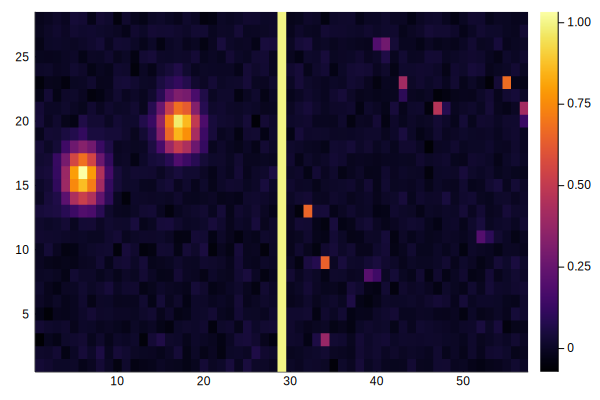

In [4]:
img_height = 28
img_width = 28
nobjects = (2, 10)
# img = generate_example(img_height, img_width, nobjects, 0.7, shape=:square)
img = generate_example(img_height, img_width, nobjects)
heatmap(hcat(img[:, :, 1], ones(img_height), img[:, :, 2]))

Now we show an example where the size of each blur does not change with the number of objects.

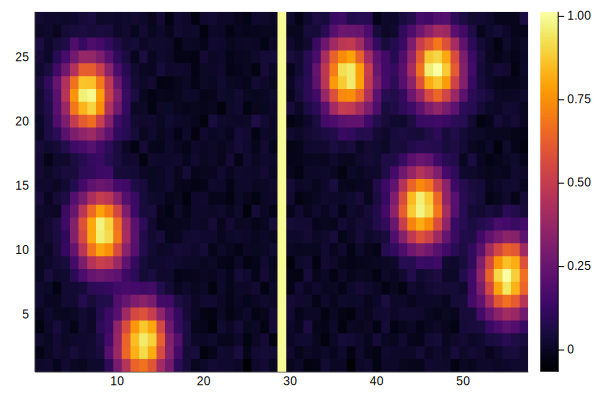

In [5]:
nobjects = (3,4)
object_size = 20
img = generate_example(img_height, img_width, nobjects, object_size, min_dist_tol=0.5)
heatmap(hcat(img[:, :, 1], ones(img_height), img[:, :, 2]))

Finally, we show an example where the objects are squares.

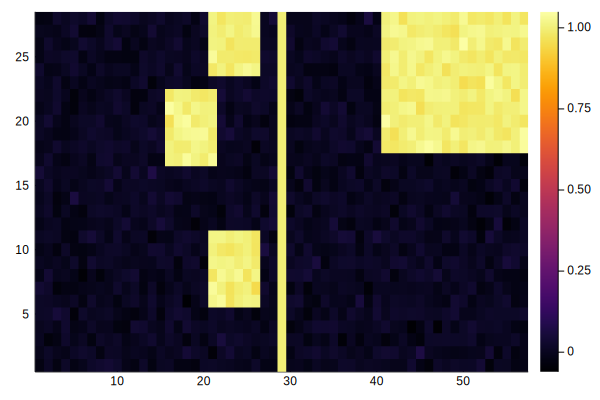

In [6]:
nobjects = (3, 1)
object_size = 1.0
img = generate_example(img_height, img_width, nobjects, object_size, min_dist_tol=0.5, shape=:square)
heatmap(hcat(img[:, :, 1], ones(img_height), img[:, :, 2]))

## Create training data
The data will be passed to the model as a $n\times m\times2$ array, where $n$ and $m$ are the height and width of the array. During training, the model will only be shown examples where there is somewhere between 1 and 5 blobs. Also, we will only show examples where the blobs are Gaussian blurs. Later, we will test the model on situations where the number of blobs is not in the range $1,2,3,4,5$ and where the objects may be sqaures. Therefore, at test time we will be assessing the model on examples that are conceptually different from the training data.

In [7]:
# Bundle images together with labels and group into minibatches.
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X)[1], size(X)[2], size(X)[3], length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] .= Float32.(X[:, :, :, idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], -1:1)
    return (X_batch, Y_batch)
end

make_minibatch (generic function with 1 method)

In [8]:
nexamples = 50_000  # Number of training examples.
batch_size = 1024
object_size = 50.0
dividing_ratio = 0.7  # Fraction of the samples that will go into the training set. The rest go into the test set.
# During training, the model will only be shown examples where there is somewhere between 1 and 5 blobs.
nobjects_range = 1:5
labels = Array{Int}(undef, nexamples)
data = Array{Float64}(undef, img_height, img_width, 2, nexamples)
@time for i in 1:2:nexamples
    nobjects = rand(nobjects_range, 2)
    # Bias the training set so that there are more examples where there are the same number of blobs on both sides.
    rand() > 0.7 && (nobjects[1] = nobjects[2])
    labels[i] = nobjects[1] > nobjects[2] ? -1 : nobjects[1] == nobjects[2] ? 0 : 1
    if rand() < 0.5
        data[:, :, :, i] .= generate_example(img_height, img_width, (nobjects[1], nobjects[2]))
    else
        data[:, :, :, i] .= generate_example(img_height, img_width, (nobjects[1], nobjects[2]), object_size,
                                             min_dist_tol=0.7)
    end
    # Generate another example where the images flip sides.
    labels[i + 1] = nobjects[2] > nobjects[1] ? -1 : nobjects[1] == nobjects[2] ? 0 : 1
    data[:, :, :, i + 1] .= reverse(data[:, :, :, i], dims=3)
end
# Split the data into test and training sets. The training set will then be further divided into batches, while the test
# set will be one very large batch.
dividing_index = round(Int, nexamples*dividing_ratio)
train_data = data[:, :, :, 1:dividing_index]
train_labels = labels[1:dividing_index]
test_data = data[:, :, :, dividing_index+1:end]
test_labels = labels[dividing_index+1:end]

mb_idxs = partition(1:dividing_index, batch_size)
train_set = [make_minibatch(train_data, train_labels, i) for i in mb_idxs]
test_set = make_minibatch(test_data, test_labels, 1:round(Int,nexamples*(1-dividing_ratio)));

 77.689785 seconds (2.55 G allocations: 186.828 GiB, 29.95% gc time)


## Show an example data point.

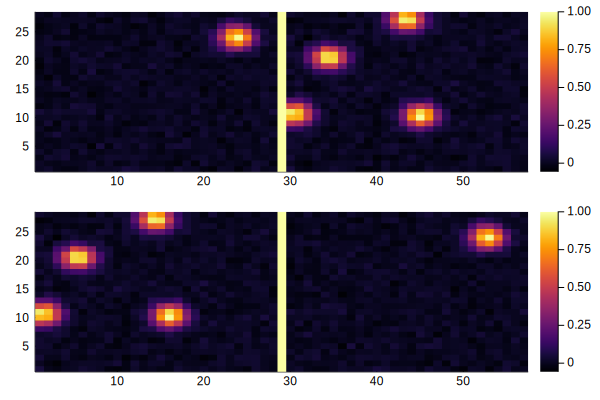

In [9]:
index = 1
p1 = heatmap(hcat(data[:, :, 1, index], ones(img_height), data[:, :, 2, index]))
p2 = heatmap(hcat(data[:, :, 1, index + 1], ones(img_height), data[:, :, 2, index + 1]))
plot(p1, p2, layout=(2, 1))

## Create the model
The model is a three layer convolutional neural network followed by some dense layers. The model is a slight tweak if the [simple convloutional neural network](https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl) example in the Flux model zoo.

In [10]:
model = Chain(
    # First convolution, operating upon a 28x28 image
    Conv((3, 3), 2=>16, pad=(1, 1), relu),
    MaxPool((2, 2)),

    # Second convolution, operating upon a 14x14 image
    Conv((3, 3), 16=>32, pad=(1, 1), relu),
    MaxPool((2, 2)),

    # Third convolution, operating upon a 7x7 image
    Conv((3, 3), 32=>32, pad=(1, 1), relu),
    MaxPool((2, 2)),

    # Reshape 3d tensor into a 2d one, at this point it should be (3, 3, 32, N)
    # which is where we get the 288 in the `Dense` layer below:
    x -> reshape(x, :, size(x, 4)),
    Dropout(0.5),
    Dense(288, 3, relu),

    # Finally, softmax to get nice probabilities
    softmax,
)

Chain(Conv((3, 3), 2=>16, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), getfield(Main, Symbol("##20#21"))(), Dropout{Float64}(0.5, true), Dense(288, 3, NNlib.relu), NNlib.softmax)

In [11]:
loss(x, y) = crossentropy(model(x), y)
loss(a::Tuple) = loss(a...)
accuracy(x, y) = mean(round.(onecold(model(x))) .== gpu(onecold(y)))
accuracy(a::Tuple) = accuracy(a...)

accuracy (generic function with 2 methods)

In [12]:
# Load model and datasets onto GPU, if enabled.
train_set = gpu.(train_set)
test_set = gpu.(test_set)
model = gpu(model)

Chain(Conv((3, 3), 2=>16, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), getfield(Main, Symbol("##20#21"))(), Dropout{Float64}(0.5, true), Dense(288, 3, NNlib.relu), NNlib.softmax)

In [13]:
opt = ADAM(1e-3)
ps = Flux.params(model);

## Training

In [14]:
niters = 100  # Number of epochs to train for.
loss_list = Array{typeof(loss(train_set[1]))}(undef, niters)  # Loss at each epoch.
test_accuracy = Array{Float64}(undef, niters)  # Model accuracy on the test set at each epoch.
@time for index in 1:niters
    test_accuracy[index] = accuracy(test_set...)
    Flux.train!(loss, ps, train_set,opt)
    finalize(ps)

    if (index == 1) || (index % 2 == 0)
        println("Epoch = ", index, ", Test set accuracy = ", test_accuracy[index])
    end
end

Epoch = 1, Test set accuracy = 0.28346666666666664
Epoch = 2, Test set accuracy = 0.3177333333333333
Epoch = 4, Test set accuracy = 0.36446666666666666
Epoch = 6, Test set accuracy = 0.42146666666666666
Epoch = 8, Test set accuracy = 0.43346666666666667
Epoch = 10, Test set accuracy = 0.4628
Epoch = 12, Test set accuracy = 0.7218666666666667
Epoch = 14, Test set accuracy = 0.7893333333333333
Epoch = 16, Test set accuracy = 0.8078
Epoch = 18, Test set accuracy = 0.8202666666666667
Epoch = 20, Test set accuracy = 0.8377333333333333
Epoch = 22, Test set accuracy = 0.8404
Epoch = 24, Test set accuracy = 0.8485333333333334
Epoch = 26, Test set accuracy = 0.8572666666666666
Epoch = 28, Test set accuracy = 0.8548666666666667
Epoch = 30, Test set accuracy = 0.8652
Epoch = 32, Test set accuracy = 0.8756666666666667
Epoch = 34, Test set accuracy = 0.8702
Epoch = 36, Test set accuracy = 0.8751333333333333
Epoch = 38, Test set accuracy = 0.8828
Epoch = 40, Test set accuracy = 0.8813333333333333
Ep

In [15]:
mean(accuracy.(train_set))

0.9361461568322982

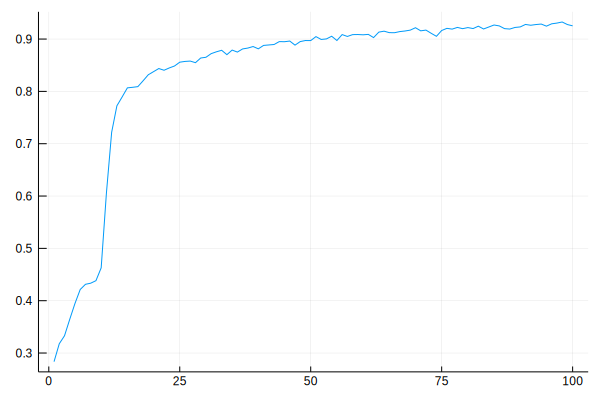

In [16]:
plot(test_accuracy, legend=nothing)

### Test the model out on freshly generated examples

In [17]:
show_result = function(model_result)
    res = onecold(model_result, -1:1)[1]
    if res == -1
        return "The left side has more blobs"
    elseif res == 0
        return "Both sides have the same number of blobs"
    elseif res == 1
        return "The right side has more blobs"
    else
        error("$(model_result) cannot be interpreted as a ternary answer.")
    end
end

#22 (generic function with 1 method)

model_result = model(imgtmp |> gpu) = Float32[2.48113e-6; 0.0071336; 0.992864] (tracked)
The right side has more blobs.


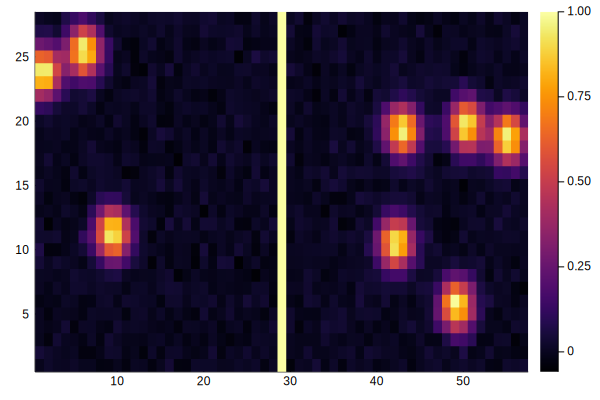

In [18]:
nobjects = (3, 5)
object_size = 50.0
# img = generate_example(img_height, img_width, nobjects, μ=10)
img = generate_example(img_height, img_width, nobjects, object_size, min_dist_tol=0.3)

heatmap(hcat(img[:, :, 1], ones(img_height), img[:, :, 2]))
imgtmp = Array{Float32}(undef, img_height, img_width, 2, 1)
imgtmp[:, :, :, 1] = img
@show model_result = model(imgtmp |> gpu)
println("$(show_result(model_result)).")

heatmap(hcat(imgtmp[:, :, 1, 1], ones(img_height), imgtmp[:, :, 2, 1]))

model_result = model(imgtmp |> gpu) = Float32[0.255005; 0.742905; 0.00209011] (tracked)
reverse_model_result = reverse(model(reverse(imgtmp; dims=3) |> gpu) |> Tracker.data; dims=1) = Float32[0.75788; 0.237149; 0.00497183]
combined_result = (model_result .+ reverse_model_result) / 2 = Float32[0.506442; 0.490027; 0.00353097] (tracked)
Normal model:
Both sides have the same number of blobs.
Combined model:
The left side has more blobs


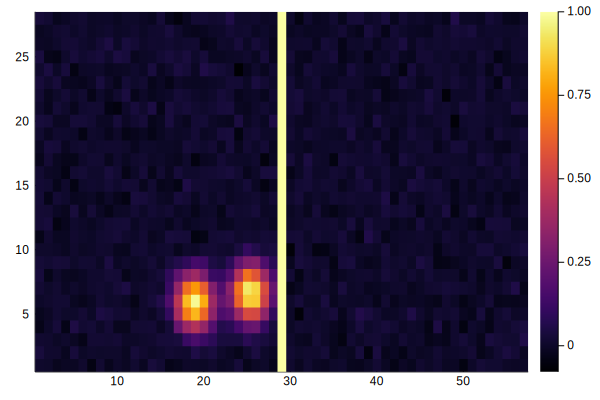

In [19]:
nobjects = (2, 0)
object_size = 50.0
img = generate_example(img_height, img_width,nobjects)
# img = generate_example(img_height, img_width, nobjects, object_size, min_dist_tol=0.7)

heatmap(hcat(img[:, :, 1], ones(img_height), img[:, :, 2]))
imgtmp = Array{Float32}(undef, img_height, img_width, 2, 1)
imgtmp[:, :, :, 1] = img
@show model_result = model(imgtmp |> gpu)
@show reverse_model_result = reverse(model(reverse(imgtmp; dims=3) |> gpu) |> Tracker.data; dims=1)
@show combined_result = (model_result .+ reverse_model_result)/2
println("Normal model:")
println("$(show_result(model_result)).")
println("Combined model:")
println(show_result(combined_result))

heatmap(hcat(imgtmp[:, :, 1, 1], ones(img_height), imgtmp[:, :, 2, 1]))

### Create an accuracy matrix
The accuracy matrix is a matrix $A$, where the element $A_{i,j}$ represents the accuracy of the model when presented with an example with $i$ objects on the left side and $j$ objects on the right side. Here, the range for the test examples is outside the range that the model was trained on. Interestingly, we see that the model has developed an abstract understanding of numbers that goes beyond what it was trained on. When looking at the accuracy matrix, bear in mind that if the model was random guessing, then the accuracy at each point in the matrix would be $\frac{1}{3}$.

 16.689306 seconds (459.59 M allocations: 23.445 GiB, 34.60% gc time)


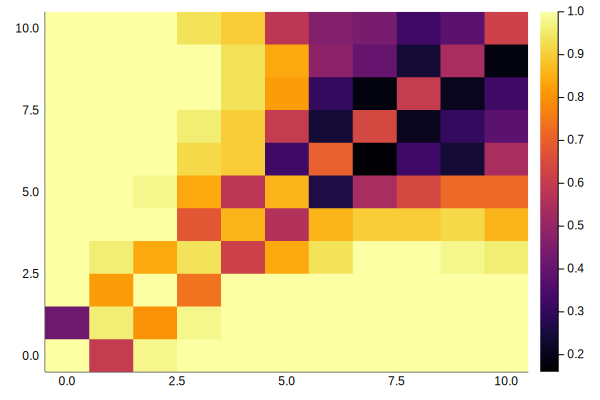

In [20]:
test_range = 0:10
niters = 50
object_size = 50.0
accuracy_matrix = Array{Float64}(undef, length(test_range), length(test_range))
imgtmp = Array{Float32}(undef, img_height, img_width, 2, 1)
@time for (index1, i) in enumerate(test_range)
    for (index2, j) in enumerate(test_range)
        nobjects = (i, j)
        ncorrect = 0
        for iter in 1:niters
            if rand() < 0.5
                img = generate_example(img_height, img_width, (nobjects[1], nobjects[2]))
            else
                img = generate_example(img_height, img_width, (nobjects[1], nobjects[2]), object_size,
                                       min_dist_tol=0.2)
            end
            imgtmp[:, :, :, 1] .= img
            onecold(model(imgtmp |> gpu))[1] - 2 == sign(j - i) && (ncorrect += 1)
        end
        accuracy_matrix[index1, index2] = ncorrect/niters
    end
end
heatmap(test_range, test_range, accuracy_matrix)

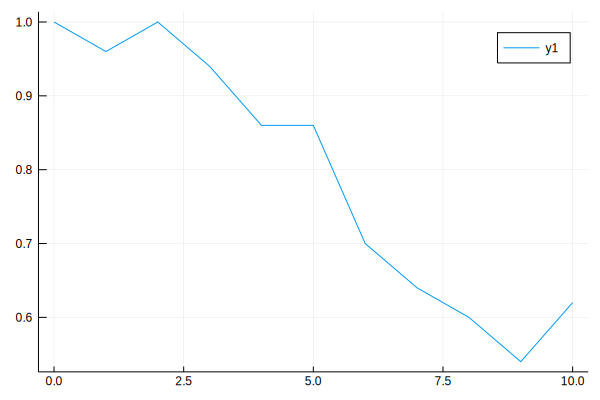

In [21]:
plot(test_range, diag(accuracy_matrix))

In [22]:
accuracy_matrix

11×11 Array{Float64,2}:
 1.0   0.6   0.98  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0 
 0.42  0.96  0.8   0.98  1.0   1.0   1.0   1.0   1.0   1.0   1.0 
 1.0   0.82  1.0   0.74  1.0   1.0   1.0   1.0   1.0   1.0   1.0 
 1.0   0.96  0.84  0.94  0.62  0.84  0.94  1.0   1.0   0.98  0.96
 1.0   1.0   1.0   0.68  0.86  0.56  0.86  0.9   0.9   0.92  0.86
 1.0   1.0   0.98  0.84  0.58  0.86  0.26  0.54  0.64  0.72  0.72
 1.0   1.0   1.0   0.92  0.9   0.32  0.7   0.16  0.32  0.24  0.54
 1.0   1.0   1.0   0.96  0.9   0.6   0.24  0.64  0.2   0.3   0.38
 1.0   1.0   1.0   1.0   0.94  0.82  0.3   0.18  0.6   0.2   0.32
 1.0   1.0   1.0   1.0   0.94  0.84  0.48  0.4   0.24  0.54  0.18
 1.0   1.0   1.0   0.94  0.9   0.58  0.46  0.44  0.32  0.38  0.62

In [29]:
mean(accuracy_matrix)

0.8105785123966943

## Test the model with squares as inputs
To further test the model we present it with examples where the objects that need to be counted are squares. Once again, the model remains numerically competent in this task which is very different from its training.

model_result = model(imgtmp |> gpu) = Float32[5.96277e-21; 7.66148e-14; 1.0] (tracked)
reverse_model_result = reverse(model(reverse(imgtmp; dims=3) |> gpu) |> Tracker.data; dims=1) = Float32[0.0; 3.16597e-26; 1.0]
combined_result = (model_result .+ reverse_model_result) / 2 = Float32[2.98138e-21; 3.83074e-14; 1.0] (tracked)
Normal model:
The right side has more blobs.
Combined model:
The right side has more blobs


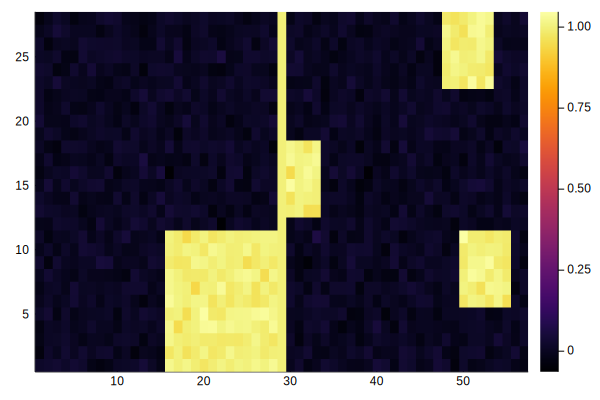

In [23]:
nobjects = (1, 3)
object_size = 1.0
img = generate_example(img_height, img_width, nobjects, object_size, shape=:square)
# img = generate_example(img_height, img_width, nobjects, object_size, min_dist_tol=0.7)

heatmap(hcat(img[:, :, 1], ones(img_height), img[:, :, 2]))
imgtmp = Array{Float32}(undef, img_height, img_width, 2, 1)
imgtmp[:, :, :, 1] = img
@show model_result = model(imgtmp |> gpu)
@show reverse_model_result = reverse(model(reverse(imgtmp; dims=3) |> gpu) |> Tracker.data; dims=1)
@show combined_result = (model_result .+ reverse_model_result)/2
println("Normal model:")
println("$(show_result(model_result)).")
println("Combined model:")
println(show_result(combined_result))

heatmap(hcat(imgtmp[:, :, 1, 1], ones(img_height), imgtmp[:, :, 2, 1]))

 23.947353 seconds (442.60 M allocations: 23.867 GiB, 40.10% gc time)


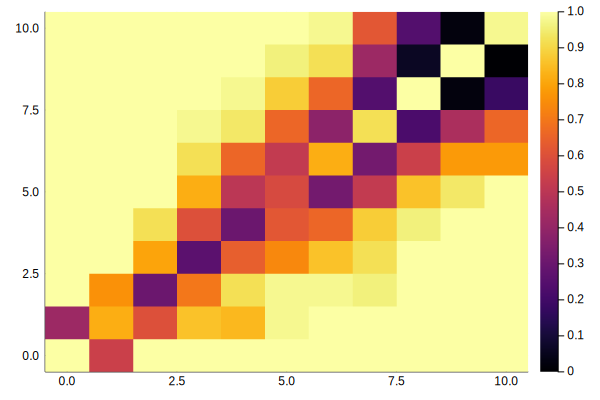

In [24]:
test_range = 0:10
niters = 50
object_size = 1.0
accuracy_matrix = Array{Float64}(undef, length(test_range), length(test_range))
imgtmp = Array{Float32}(undef, img_height, img_width, 2, 1)
@time for (index1, i) in enumerate(test_range)
    for (index2, j) in enumerate(test_range)
        nobjects = (i, j)
        ncorrect = 0
        for iter in 1:niters
            img = generate_example(img_height, img_width, (nobjects[1], nobjects[2]), object_size,
                                   min_dist_tol=0.2, shape=:square)
            imgtmp[:, :, :, 1] .= img
            model_result = model(imgtmp |> gpu)
            reverse_model_result = reverse(model(reverse(imgtmp; dims=3) |> gpu) |> Tracker.data; dims=1)
            combined_result = (model_result .+ reverse_model_result)/2
            onecold(combined_result)[1] - 2 == sign(j - i) && (ncorrect += 1)
#             onecold(model_result)[1] - 2 == sign(j - i) && (ncorrect += 1)
        end
        accuracy_matrix[index1, index2] = ncorrect/niters
    end
end
heatmap(test_range, test_range, accuracy_matrix)

In [25]:
accuracy_matrix

11×11 Array{Float64,2}:
 1.0   0.54  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0 
 0.42  0.82  0.6   0.86  0.84  0.98  1.0   1.0   1.0   1.0   1.0 
 1.0   0.76  0.3   0.7   0.92  0.98  0.98  0.96  1.0   1.0   1.0 
 1.0   1.0   0.8   0.26  0.64  0.74  0.86  0.92  1.0   1.0   1.0 
 1.0   1.0   0.92  0.6   0.3   0.62  0.66  0.88  0.96  1.0   1.0 
 1.0   1.0   1.0   0.82  0.5   0.58  0.32  0.52  0.86  0.94  1.0 
 1.0   1.0   1.0   0.92  0.66  0.52  0.82  0.32  0.54  0.78  0.78
 1.0   1.0   1.0   0.98  0.94  0.66  0.38  0.92  0.22  0.46  0.66
 1.0   1.0   1.0   1.0   0.98  0.88  0.66  0.24  1.0   0.02  0.18
 1.0   1.0   1.0   1.0   1.0   0.96  0.92  0.42  0.06  1.0   0.0 
 1.0   1.0   1.0   1.0   1.0   1.0   0.98  0.62  0.24  0.02  0.98

In [28]:
mean(accuracy_matrix)

0.8105785123966943

## Conclusions
The model was trained on images that had 1 to 5 gaussian blurs in them. The model is able to classify images where the objects in the images are squares rather than gaussain blurs. The model is also able to to classify examples where the number of blobs is outside of the training range. In particular, the model is able to classify examples where there are zero objects in one or both of the images. In other words, the model is able to understand numbers in an abstract way and the model understands that $0<n$ for $n\ge1$ and $0=0$.

The original question that we set out to answer was: What is the minimum complexity for an information processing system that can understand zero at an abstract level? We can now see that a small neural network is able to understand zero. Previously, the most simple system able to perform the same task was a honey bee. This work significantly reduces the required complexity to understand zero.